# Setting  a GP on H(z)
we are going to use data on H(z), dA(z); an integral of H(z) and f(z); the solution of a differential equation on H(z)

# Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy.integrate import quad
import pyccl as ccl
import arviz as az
import theano
import theano.tensor as tt
import os
import utils
%matplotlib inline

# Make data

In [24]:
rels_dA  = [2.78, 1.87, 1.45, 1.19, 1.01, 0.87, 0.77, 
         0.76, 0.88, 0.91, 0.91, 0.91, 1.00, 1.17, 
         1.50, 2.36, 3.62, 4.79]
rels_H = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
         1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
         2.04, 3.15, 4.87, 6.55]
rels_fs = [3.60, 2.55, 2.17, 1.91, 1.60, 1.24, 
         1.18, 1.11, 1.13, 1.12, 1.12, 1.14, 1.26, 
         1.47, 1.89, 3.06, 5.14, 7.66]

In [25]:
dz = 0.1
z_arr = np.arange(0.15, 1.85+0.1, dz)

dz_f = 0.01
z_arr_f = np.arange(0.0, 1.85+0.1, dz_f)

In [26]:
tools = utils.utils()

Planck = tools.get_preds(z_arr_f, mode = 'Planck')
#Riess = tools.get_preds(z_arr_f, mode = 'Riess')

In [27]:
H0 = tools.H0
c = tools.c
Wm0 = 0.321
WL = 0.679
WmHkms2 = Wm0*(H0*c/1000)**2
WLHkms2 = WL*(H0*c/1000)**2

We make an array of redsifts at which we make our data points and a secondary finer array to gain precision when applying numerical methods

In [28]:
a_arr_f = 1/(1+z_arr_f) 
x_arr_f = np.log(a_arr_f)
idx = np.array([int(x) for x in z_arr/(dz_f)])

Position of data points

We are going to set our GP in H*c/1000 as opposed to just H becuase Pymc3 washes scales around the order of magnitude of H 

In [29]:
Hkms_arr = Planck['Hkms_arr'][idx]
H_arr = Planck['H_arr'][idx]
dA_arr = Planck['dA_arr'][idx]

In [30]:
sig_H_arr = H_arr*rels_H/100
sig_Hkms_arr = sig_H_arr*c/1000
sig_dA_arr = dA_arr*rels_dA/100

Add signal to reconstruct

In [31]:
add_signal = False
if add_signal: 
    signal = tools.get_signal(z_arr_f)
else:
    signal = np.zeros_like(z_arr_f)

In [32]:
Hkms_data = (Planck['Hkms_arr']+signal)[idx] #+ np.random.randn(len(z_arr))*sig_Hkms_arr
H_data = Hkms_data*1000/c
dA_data = (dz_f*np.cumsum((c/1000)/(Planck['Hkms_arr']+signal))/(1+z_arr_f))[idx] #+ np.random.randn(len(z_arr))*sig_dA_arr

In [33]:
Hkms_test = np.sqrt(WmHkms2*(1+z_arr_f)**3+WLHkms2)

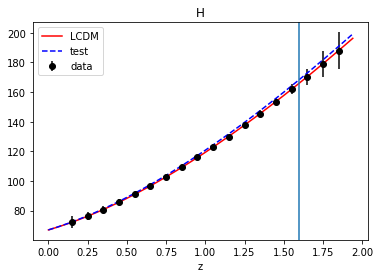

In [34]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, Hkms_test, "b--", label='test')
plt.errorbar(z_arr, Hkms_data, yerr = sig_Hkms_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

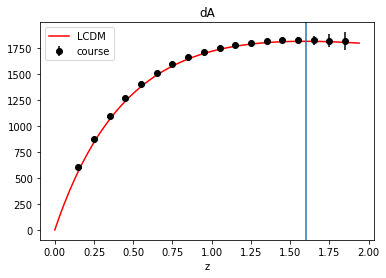

In [35]:
plt.plot(z_arr_f, Planck['dA_arr'], "r-", label='LCDM')
plt.errorbar(z_arr, dA_data, yerr = sig_dA_arr, fmt='ko', label='course')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("dA")
plt.legend();

Solve f(z) from H(z)

In [36]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

def wrap(f, z, Wm, q):
    dfdz = (-1/(1+z))*((3/2)*Wm(z) - f**2 - q(z)*f)
    return dfdz

def make_f(H):  
    #Make Wm
    Wm0 = 0.315
    fz0 = classy.growthrate_at_z(1.94)
    Wm =  Wm0*(H0/H)**2*(1+z_arr_f)**3
    #Make q
    comf_H = a_arr_f*H
    diff_comf_H = np.gradient(comf_H)/np.gradient(x_arr_f)
    q = 1 + diff_comf_H/comf_H
    
    Wm_inter = interp1d(z_arr_f, Wm, kind='cubic', bounds_error=False, fill_value='extrapolate')
    q_inter = interp1d(z_arr_f, q, kind='cubic', bounds_error=False, fill_value='extrapolate')

    f = odeint(wrap, fz0, z_arr_f[::-1], args=(Wm_inter, q_inter))
        
    return  np.array(f.flatten()[::-1])

def make_sigma8(f):  
    #Make Wm
    Wm0 = 0.315
    s80 = pm.Normal("s80", mu=0.811, sigma=0.01)
    s8_gp_f = tt.zeros(len(z_train_f))
    s8_gp_f = tt.inc_subtensor(s8_gp_f[0], s80)
    for i in np.arange(1, len(z_train_f)):
        k0 = -1*(f_gp_f[i-1]*s8_gp_f[i-1])/(1+z_train_f[i-1])
        s8_gp_f = tt.inc_subtensor(s8_gp_f[i], s8_gp_f[i-1] + dz_f*(k0))
    s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f) 
    
    fs8_gp_f = f_gp_f*s8_gp_f
    fs8_gp_f = pm.Deterministic("fs8_gp_f", fs8_gp_f) 
    
        
    return  np.array(f.flatten()[::-1])

In [37]:
sig_fs_arr = (Planck['f_arr']*Planck['s8_arr'])[idx]*rels_fs/100
fs_data = (Planck['f_arr']*Planck['s8_arr'])[idx] #+ np.random.randn(len(z_arr))*sig_fs_arr

In [38]:
data = np.concatenate([H_data, dA_data, fs_data])

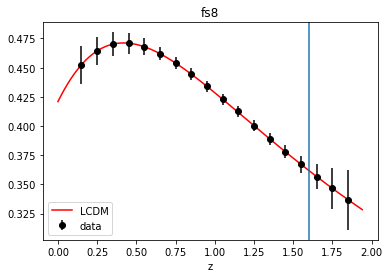

In [39]:
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "r-", label='LCDM')
plt.errorbar(z_arr, fs_data, yerr = sig_fs_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("fs8")
plt.legend();

Training selection 

In [40]:
z_cut = 2
z_train = z_arr[z_arr<z_cut]
z_train_f = z_arr_f[z_arr_f<z_cut]
a_train_f = 1/(1+z_train_f) 
x_train_f = np.log(a_train_f)
Hkms_train = Hkms_data[z_arr<z_cut]
H_train = H_data[z_arr<z_cut]
dA_train = dA_data[z_arr<z_cut]
fs_train = fs_data[z_arr<z_cut]
background = Planck['Hkms_arr'][z_arr_f<z_cut]

Make covariance matrices

In [41]:
Hkms_cov = np.zeros([len(z_train), len(z_train)])
H_cov = np.zeros([len(z_train), len(z_train)])
dA_cov = np.zeros([len(z_train), len(z_train)])
fs_cov = np.zeros([len(z_train), len(z_train)])
for i in np.arange(len(z_train)):
    Hkms_cov[i,i] = sig_Hkms_arr[i]**2
    H_cov[i,i] = sig_H_arr[i]**2
    dA_cov[i,i] = sig_dA_arr[i]**2
    fs_cov[i,i] = sig_fs_arr[i]**2
    
data_cov = np.block([[H_cov, np.zeros_like(H_cov), np.zeros_like(H_cov)],
                     [np.zeros_like(H_cov), dA_cov, np.zeros_like(H_cov)],
                     [np.zeros_like(H_cov), np.zeros_like(H_cov), fs_cov]])

In [42]:
data_cov

array([[1.65434194e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.97249778e-11, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.25119604e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.19066664e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.17171618e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.65398648e-04]])

# Get mean of GP
We are not using this at the moment

In [21]:
from scipy.optimize import least_squares
def loss_func(coeffs, data, cov, z_output, z_data):
    idx = np.array([int(x) for x in z_data/dz_f])
    inv_cov = np.linalg.inv(data_cov)
    Hkms_arr = tools.H_model(z_output, coeffs)
    H_arr = Hkms_arr*1000/c
    dA_arr = tools.make_dM(H_arr, z_output)/(1+z_output)
    fs8_arr = np.zeros_like(z_output) #tools.make_f(H_arr, z_output)
    theory = np.concatenate([H_arr[idx], dA_arr[idx], fs8_arr[idx]])
    diff = data - theory
    xi2 = np.dot(np.dot(diff, inv_cov), diff)
    return np.sqrt(xi2)

def get_H_fit(z_output, z_data):
    x0 = [70, 0.675, 0.003]
    x = least_squares(loss_func, x0, args=(data, data_cov, z_output, z_data))
    best_coeffs = x['x']
    return tools.H_model(z_output, best_coeffs)

In [43]:
Hkms_fit = tools.get_H_fit(z_arr_f, z_arr, Hkms_data, Hkms_cov)

[65.9792757  36.86602968 32.45028046]


In [ ]:
plt.plot(z_arr_f, Planck['Hkms_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, Hkms_fit, 'b-', label = 'Best fit')
plt.errorbar(z_arr, Hkms_data, yerr = sig_Hkms_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

In [ ]:
plt.plot(z_arr_f, Planck['dA_arr'], "r-", label='LCDM')
plt.plot(z_arr_f, tools.make_dM(Hkms_fit*1000/c, z_arr_f)/(1+z_arr_f), 'b-', label = 'Best fit')
plt.errorbar(z_arr, dA_data, yerr = sig_dA_arr, fmt='ko', label='data')
plt.axvline(x=1.6)

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

In [ ]:
fsdfsdfs

# Set up GP

The key point of Pymc3 is that the GP is treated pseudo-numerically. what I mean by this is that when Pymc3 initializes the Gaussian process it creates an array of realizations of the GP over a given array of redshifts. The problem is that the GP is not really an array but a tensor and the entries are not numbers but symbolic variables that stand for the potential values of the GP realizations during the sampling process.  

Thus when performing operations we want to create a symbolic graph for the role of each realization of the GP in the numerical algorithm we employ to transform the GP. 

In [ ]:
n_tune = 100
n_samples = 100

In [ ]:
with pm.Model() as model:
    #Define parameters
    ℓ = pm.InverseGamma("ℓ", alpha=2, beta=1) 
    η = pm.HalfNormal("η", sigma=8) 
    gp_cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Set up Gaussian process
    gp_f = gp.prior("gp_f", X=z_train_f[:, None]) 
    WLHkms2_gp_f = pm.Deterministic("WLHkms2_gp_f", tt.as_tensor_variable(WLHkms2*(1+gp_f/100))) 
    WmHkms2 = pm.Normal("WmHkms2", mu=1440.969, sigma=144)
    Hkms_gp_f = pm.Deterministic("Hkms_gp_f", tt.sqrt(WmHkms2*(1+z_arr_f)**3+WLHkms2_gp_f))
    H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(Hkms_gp_f*1000/c))
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp_f[0])) 
    
    #Numerical integration scheme
    dH_gp_f = pm.Deterministic("dH_gp_f", tt.as_tensor_variable(1/H_gp_f))
    dA_gp_f = tt.zeros(len(z_train_f))
    dA_gp_f = tt.inc_subtensor(dA_gp_f[1:],
              tt.as_tensor_variable(dz_f*tt.cumsum(dH_gp_f)[:-1]/(1+z_train_f)[1:]))
    dA_gp_f = pm.Deterministic('dA_gp_f', dA_gp_f)

    #Second order differentiation scheme
    Wm = pm.Deterministic("Wm", (WmHkms2/Hkms_gp_f**2)*(1+z_train_f)**3)
    comf_H = pm.Deterministic("comf_H", a_train_f*H_gp_f)
    diff_comf_H = tt.zeros(len(z_train_f))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_train_f[1]-x_train_f[0]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_train_f[2:]-x_train_f[:-2]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_train_f[-1]-x_train_f[-2]))
    diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
    q = 1+(diff_comf_H/comf_H)
    
    #Implement second Order Runge-Kutta method
    Df = pm.Normal("Df", mu=0.057, sigma=0.00015) 
    f0 = pm.Deterministic('f0', 1-Df) 
    f_gp_f = tt.zeros(len(z_train_f))
    f_gp_f = tt.inc_subtensor(f_gp_f[-1], f0)
    for i in np.arange(1, len(z_train_f)):
        k0 = (-1/(1+z_train_f[-i]))*((3/2)*Wm[-i]-f_gp_f[-i]**2-q[-i]*f_gp_f[-i])
        f1 = f_gp_f[-i]-dz_f*k0
        k1 = (-1/(1+z_train_f[-(i+1)]))*((3/2)*Wm[-(i+1)]-f1**2-q[-(i+1)]*f1)
        f_gp_f = tt.inc_subtensor(f_gp_f[-(i+1)], f_gp_f[-i]-dz_f*(k1+k0)/2)
    f_gp_f = pm.Deterministic("f_gp_f", f_gp_f) 
    
    #integrate for s8 method2
    s80 = pm.Normal("s80", mu=0.811, sigma=0.01)
    s8_gp_f = tt.zeros(len(z_train_f))
    s8_gp_f = tt.inc_subtensor(s8_gp_f[0], s80)
    for i in np.arange(1, len(z_train_f)):
        k0 = -1*(f_gp_f[i-1]*s8_gp_f[i-1])/(1+z_train_f[i-1])
        s8_gp_f = tt.inc_subtensor(s8_gp_f[i], s8_gp_f[i-1] + dz_f*(k0))
    s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f) 
    
    fs8_gp_f = f_gp_f*s8_gp_f
    fs8_gp_f = pm.Deterministic("fs8_gp_f", fs8_gp_f) 
    
    #Evaluate arrays at data points
    idx = np.array([int(x) for x in z_train/dz_f])
    H_gp = pm.Deterministic('H_gp', tt.as_tensor_variable(H_gp_f[idx]))
    dA_gp = pm.Deterministic('dA_gp', tt.as_tensor_variable(dA_gp_f[idx]))
    fs8_gp = pm.Deterministic('fs8_gp', tt.as_tensor_variable(fs8_gp_f[idx]))

    #Set up Gaussian likelihoods
    lkl = pm.MvNormal("H_obs", mu=H_gp, cov=H_cov, observed=H_train)
    lkl *= pm.MvNormal("dA_obs", mu=dA_gp, cov=dA_cov, observed=dA_train)
    lkl *= pm.MvNormal("fs8_obs", mu=fs8_gp, cov=fs_cov, observed=fs_train)

    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune)

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
R_stat =pm.summary(trace)['r_hat'][["ℓ","η","Wm0", "H0_gp", "s80", 'Df']]
print(R_stat)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['Hkms_arr']*1000/c, "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], H_data, yerr=sig_H_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dA_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['dA_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], dA_data, yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("dA(z)")
plt.title("dA(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp_f"][0, :, :], z_train_f[:, None])
plt.plot(z_arr_f, Planck['f_arr']*Planck['s8_arr'], "b-", label='LCDM')

# plot the data and the true latent function
plt.axvline(x=1.6)
ax.errorbar(z_arr[:, None], fs_data, yerr=sig_fs_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["s8_gp_f"])[0, :, :], z_train_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['s8_arr'], "b-", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("sigma8(z)")
plt.title("sigma8(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["f_gp_f"])[0, :, :], z_train_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], Planck['f_arr'], "b-", label=r'$LCDM$')

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();

In [ ]:
#z_new
# add the GP conditional to the model, given the new X values
z_new = np.arange(0., 3+0.1, 0.01)[:, None]
with model:
    DHkms_pred = gp.conditional("DHkms_pred", z_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["DHkms_pred"])

In [ ]:
Hkms_new = np.array([])
for z in z_new: 
            #We can worry about the rs_drag later
            Hkms = classy.Hubble(z)*utils.c/1000
            Hkms_new = np.append(Hkms_new, Hkms)

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["DHkms_pred"]+Hkms_new, z_new)
# plot the data and the true latent function
plt.plot(z_new, Hkms_new, "dodgerblue", lw=2, label="LCDM")
ax.errorbar(z_arr[:, None], Hkms_data , yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel(r'$Hkms$')
#plt.ylim([-1.3, 4])
#plt.xlim([0, 3])
plt.legend();

# Validation

In [ ]:
z_test = z_arr[z_arr>z_cut]
z_test_f = z_arr_f[z_arr_f>z_cut]
a_test_f = 1/(1+z_test_f) 
x_test_f = np.log(a_test_f)
Hkms_test = Hkms_data[z_arr>z_cut]
H_test = H_data[z_arr>z_cut]
dA_test = dA_data[z_arr>z_cut]
fs_test = fs_data[z_arr>z_cut]
background = Hkms_arr_f[z_arr_f>z_cut]

In [ ]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [ ]:
prediction = (pred_samples["DHkms_pred"]+Hkms_new)[idx]
pred_m, pred_s = get_m_s(prediction)

In [ ]:
idx = np.array([int(x) for x in z_test/dz_f])
pred_data = pred_m[idx]
pred_err = sig_Hkms_arr[z_arr>1.6]

In [ ]:
residuals = (Hkms_test-pred_data)/pred_err

In [ ]:
plt.plot(z_test_f, np.zeros_like(z_test_f), 'b--')
plt.plot(z_test, residuals, 'ro', label='residuals')
plt.fill_between(z_test_f, np.ones_like(z_test_f), -np.ones_like(z_test_f), color='b', alpha=.3)
plt.fill_between(z_test_f, 2*np.ones_like(z_test_f), -2*np.ones_like(z_test_f), color='b', alpha=.3)
plt.xlabel("z")
plt.legend();

In [ ]:
xi2 = np.sqrt(np.dot((Hkms_test-pred_data)/pred_err, (Hkms_test-pred_data)/pred_err))/3

In [ ]:
xi2

In [ ]:
path = 'DESIfs8_Lambda_{}_{}'.format(n_samples, n_tune)

DH_pred = pred_samples['DHkms_pred']
Hz =np.array(trace.posterior["H_gp_f"])
Hz = Hz.reshape(-1, Hz.shape[-1])
dAz = np.array(trace.posterior["dA_gp_f"])
dAz = dAz.reshape(-1, dAz.shape[-1])
fz = np.array(trace.posterior["f_gp_f"])
fz= fz.reshape(-1, fz.shape[-1])
sigma8z = np.array(trace.posterior["s8_gp_f"])
sigma8z = sigma8z.reshape(-1, sigma8z.shape[-1])
fs8z = np.array(trace.posterior["fs8_gp_f"])
fs8z = fs8z.reshape(-1, fs8z.shape[-1])
n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
Df = np.array(trace.posterior["Df"]).flatten()
H0 = np.array(trace.posterior["H0_gp"]).flatten()
Omega_m = np.array(trace.posterior["Wm0"]).flatten()
sigma8 = np.array(trace.posterior["s80"]).flatten()

os.mkdir(path)
np.savez(os.path.join(path,'samples.npz'), 
         DH_pred = DH_pred,
         z_new = z_new,
         Hz=Hz,
         dAz=dAz,
         fz=fz,
         sigma8z=sigma8z,
         fs8z=fs8z,
         n=n,
         l=l,
         Df=Df,
         H0=H0,
         Omega_m=Omega_m,
         sigma8=sigma8)